<a href="https://colab.research.google.com/github/WeilongYE/unet-for-cityscapes-road-segmentation/blob/main/unet_for_cityscapes_road_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet for Cityscapes Road Segmentation

## Table of Contents
- 1. Data Preparation
  - 1.1 Download Datasets
    - 1.1.1 Setup Kaggle API Key in Colab
    - 1.1.2 Download Cityscapes RGB Images
    - 1.1.3 Inspect RGB Images
    - 1.1.4 Reorgnize RGB Images
    - 1.1.5 Download Fine Annotations
    - 1.1.6 Inspect Label Images
    - 1.1.7 Reorgnize Label Images
    - 1.1.8 Check Relative RGB and Label Images
  - 1.2 Data Inspection
    - 1.2.1 General Info
    - 1.2.2 Label Info
  - 1.3 Load and Preprocess Datasets
    - 1.3.1 Binary Datasets

## 1. Data Preparation

### 1.1 Download Datasets
All the datasets are downloaded from Kaggle.

#### 1.1.1 Setup Kaggle API Key in Colab

In [2]:
# Step 1: Get the Kaggle API Key. https://www.kaggle.com/docs/api#authentication
# - Go to Kaggle and log in.
# - Click on your profile picture (top right), then select Settings.
# - Scroll down to the API section and click Create New API Token.
# - A file named kaggle.json will be downloaded.
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Step 2: Move kaggle key to proper location
import os
import shutil
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

Saving kaggle.json to kaggle.json


#### 1.1.2 Download Cityscapes RGB Images
Kaggle datasets link: https://www.kaggle.com/datasets/chrisviviers/cityscapes-leftimg8bit-trainvaltest

In [3]:
# Downlad datasets from Kaggle
import kagglehub
path = kagglehub.dataset_download("chrisviviers/cityscapes-leftimg8bit-trainvaltest")
print("Path to dataset files:", path)

100%|██████████| 10.8G/10.8G [01:54<00:00, 101MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/chrisviviers/cityscapes-leftimg8bit-trainvaltest/versions/1


In [4]:
downloaded_rgb_dir = "downloaded_datasets/rgb"
shutil.rmtree(downloaded_rgb_dir, ignore_errors=True)
os.makedirs(downloaded_rgb_dir, exist_ok=True)
shutil.move(path, downloaded_rgb_dir)

'downloaded_datasets/rgb/1'

#### 1.1.3 Inspect RGB Images

2975
500
(1024, 2048, 3)
(1024, 2048, 3)


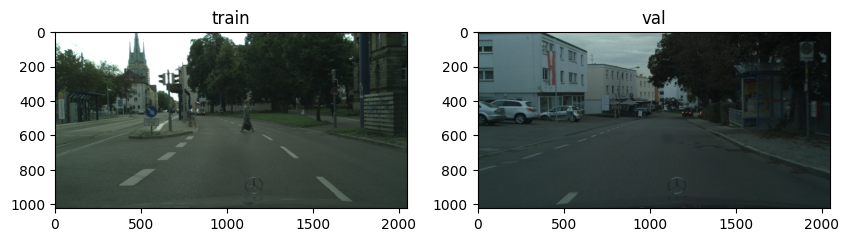

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def get_all_files(dir_name):
  file_paths = []
  for root, dirs, files in os.walk(dir_name):
    for file in files:
      file_paths.append(os.path.join(root, file))
  return file_paths

all_files = get_all_files("downloaded_datasets/rgb/1")

downloaded_train_rgb_files = [file for file in all_files if "leftImg8bit" in file and "train" in file]
downloaded_val_rgb_files = [file for file in all_files if "leftImg8bit" in file and "val" in file]
print(len(downloaded_train_rgb_files))
print(len(downloaded_val_rgb_files))

train_rgb_img = np.array(Image.open(downloaded_train_rgb_files[0]))
val_rgb_img = np.array(Image.open(downloaded_val_rgb_files[0]))
print(train_rgb_img.shape)
print(val_rgb_img.shape)
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("train")
axis[0].imshow(train_rgb_img)
axis[1].set_title("val")
axis[1].imshow(val_rgb_img)
plt.show()

#### 1.1.4 Reorgnize RGB Images
The struture should be:
- cityscapes_data/train/rgb/filename.png
- cityscapes_data/val/rgb/filename.png

In [6]:

train_rgb_dir = os.path.join("cityscapes_data/train/rgb")
val_rgb_dir = os.path.join("cityscapes_data/val/rgb")
os.makedirs(train_rgb_dir, exist_ok=True)
os.makedirs(val_rgb_dir, exist_ok=True)

for file in downloaded_train_rgb_files:
  dst_filename = os.path.basename(file.replace("_leftImg8bit", ""))
  shutil.move(file, os.path.join(train_rgb_dir, dst_filename))

for file in downloaded_val_rgb_files:
  dst_filename = os.path.basename(file.replace("_leftImg8bit", ""))
  shutil.move(file, os.path.join(val_rgb_dir, dst_filename))

2975
500


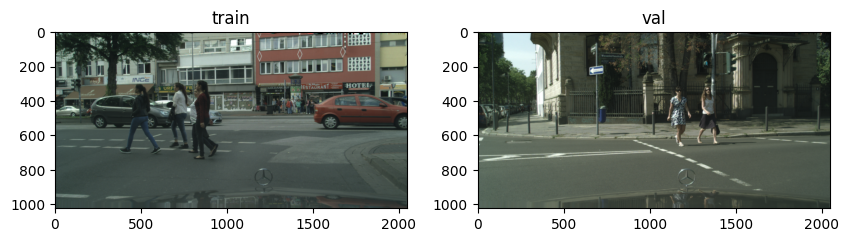

In [7]:
# Check re-orgnized rgb files

train_rgb_files = os.listdir(train_rgb_dir)
val_rgb_files = os.listdir(val_rgb_dir)
print(len(train_rgb_files))
print(len(val_rgb_files))

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("train")
axis[0].imshow(Image.open(os.path.join(train_rgb_dir, train_rgb_files[0])))
axis[1].set_title("val")
axis[1].imshow(Image.open(os.path.join(val_rgb_dir, val_rgb_files[0])))
plt.show()

#### 1.1.5 Download Fine Annotations
Kaggle datasets link: https://www.kaggle.com/datasets/devmaxime/cityscapes-fine-annotations

In [8]:
# Download datasets
path = kagglehub.dataset_download("devmaxime/cityscapes-fine-annotations")

print("Path to dataset files:", path)

100%|██████████| 240M/240M [00:02<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devmaxime/cityscapes-fine-annotations/versions/1


In [9]:
downloaded_label_dir = "downloaded_datasets/label"
shutil.rmtree(downloaded_label_dir, ignore_errors=True)
os.makedirs(downloaded_label_dir, exist_ok=True)
shutil.move(path, downloaded_label_dir)

'downloaded_datasets/label/1'

#### 1.1.6 Inspect Label Images

2975
500
(1024, 2048)
(1024, 2048)


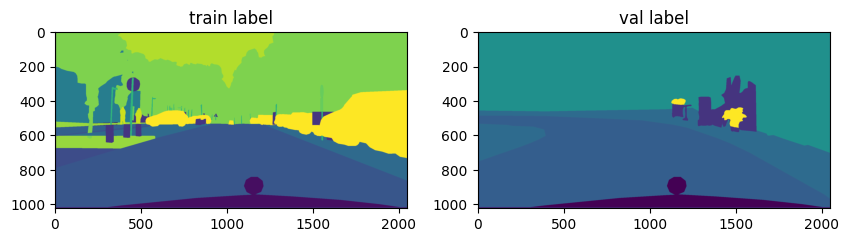

In [10]:
all_files = get_all_files("downloaded_datasets/label/1")
downloaded_train_labelIds_files = [file for file in all_files if "gtFine_labelIds" in file and "train" in file]
downloaded_val_labelIds_files = [file for file in all_files if "gtFine_labelIds" in file and "val" in file]
print(len(downloaded_train_labelIds_files))
print(len(downloaded_val_labelIds_files))

train_labelIds_img = np.array(Image.open(downloaded_train_labelIds_files[0]))
val_labelIds_img = np.array(Image.open(downloaded_val_labelIds_files[0]))
print(train_labelIds_img.shape)
print(val_labelIds_img.shape)

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("train label")
axis[0].imshow(train_labelIds_img)
axis[1].set_title("val label")
axis[1].imshow(val_labelIds_img)
plt.show()

#### 1.1.7 Reorgnize Label Images
The structure should be like:
- cityscapes_data/train/label_ids/filename.png
- cityscapes_data/val/label_ids/filename.png

In [11]:
# Create folders
train_label_dir = os.path.join("cityscapes_data/train/label")
val_label_dir = os.path.join("cityscapes_data/val/label")
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

for file in downloaded_train_labelIds_files:
  dst_filename = os.path.basename(file.replace("_gtFine_labelIds", ""))
  shutil.copy(file, os.path.join(train_label_dir, dst_filename))

for file in downloaded_val_labelIds_files:
  dst_filename = os.path.basename(file.replace("_gtFine_labelIds", ""))
  shutil.copy(file, os.path.join(val_label_dir, dst_filename))

2975
500


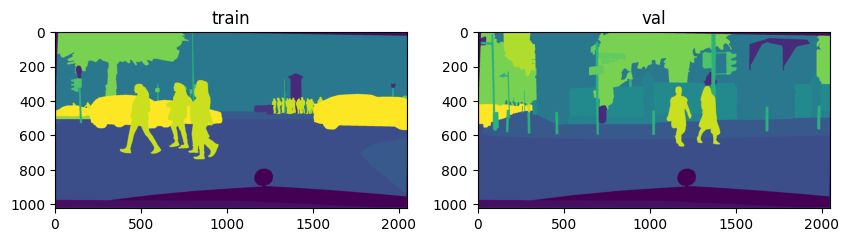

In [12]:
# Check re-orgnized label images
train_label_files = os.listdir(train_label_dir)
val_label_files = os.listdir(val_label_dir)
print(len(train_label_files))
print(len(val_label_files))

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("train")
axis[0].imshow(Image.open(os.path.join(train_label_dir, train_label_files[0])))
axis[1].set_title("val")
axis[1].imshow(Image.open(os.path.join(val_label_dir, val_label_files[0])))
plt.show()

#### 1.1.8 Check Relative RGB and Label Images

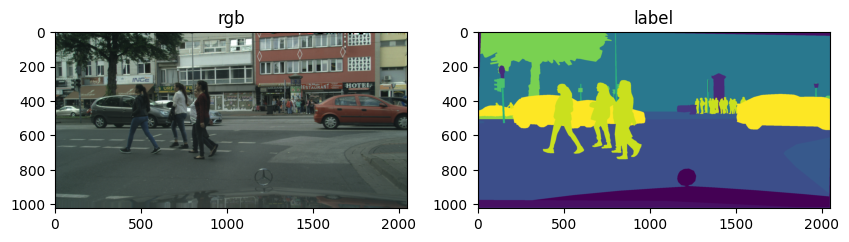

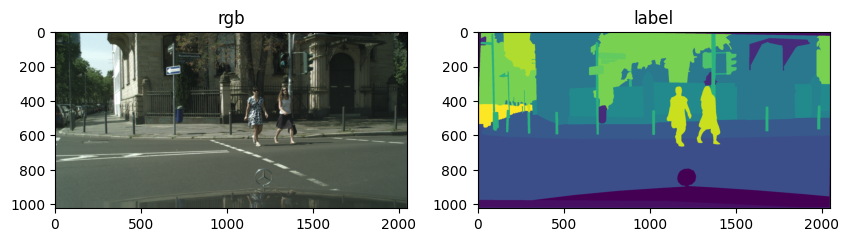

In [13]:
# Check if all filenamess in train/rgb are also in train/label
for file in train_rgb_files:
  if file not in train_label_files:
    print(file)

common_filename = train_rgb_files[0]
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("rgb")
axis[0].imshow(Image.open(os.path.join(train_rgb_dir, common_filename)))
axis[1].set_title("label")
axis[1].imshow(Image.open(os.path.join(train_label_dir, common_filename)))
plt.show()

# Check if all filenamess in val/rgb are also in val/label
for file in val_rgb_files:
  if file not in val_label_files:
    print(file)

common_filename = val_rgb_files[0]
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("rgb")
axis[0].imshow(Image.open(os.path.join(val_rgb_dir, common_filename)))
axis[1].set_title("label")
axis[1].imshow(Image.open(os.path.join(val_label_dir, common_filename)))
plt.show()

### 1.2 Data Inspection

#### 1.2.1 General Info
- Number of train samples: 2975
- Number of val samples: 500
- Shape of RGB images: (1024, 2048, 3)
- Shape of label images: (1024, 2048)

#### 1.2.2 Label Info
Below code cell is a partial copy of https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py


In [14]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [15]:
name_to_id = {label.name: label.id for label in labels}
road_id = name_to_id["road"]
print(f"The id of road is: {road_id}")

The id of road is: 7


(1024, 2048, 1)
[ 1  2  3  4  5  7  8 11 17 19 20 21 22 24 25 26]


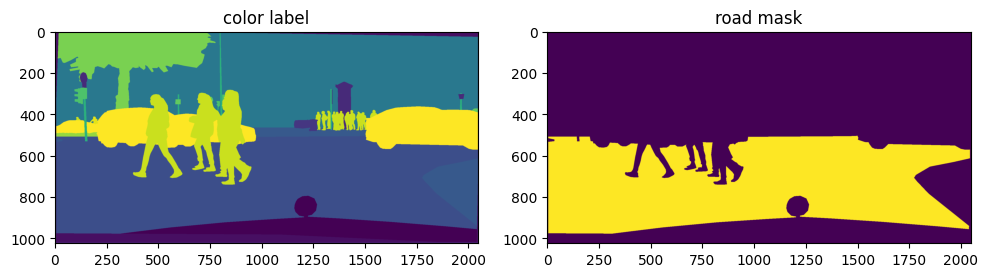

In [16]:
# Inspect one label image
one_label_img = np.array(Image.open(os.path.join(train_label_dir, train_label_files[0])))
# reshape label image to three dimention
one_label_img = np.reshape(one_label_img, (one_label_img.shape[0], one_label_img.shape[1], 1))
print(one_label_img.shape)
print(np.unique(one_label_img))

road_mask = np.all(one_label_img == road_id, axis=-1).astype(np.uint8)
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(one_label_img)
axis[0].set_title("color label")
axis[1].imshow(road_mask)
axis[1].set_title("road mask")
plt.tight_layout()
plt.show()

### 1.3 Load and Preprocess Datasets
In this experiment, three strategies will be used:
- Binary semantic segmentation: road class vs non-road class
- Multi-class semantic segmentation based on *id*

Constraints:
- Three dataset should have same resolution

In [17]:
input_shape = (256, 256, 3)

In [24]:
import keras
class DataLoader:
  @staticmethod
  def preprocess_rgb(image: Image, input_shape) -> np.ndarray:
    # resize to input shape
    image = image.resize(input_shape[:2], Image.NEAREST)
    # normalize
    image = np.array(image) / 255.0
    return image

  @staticmethod
  def preprocess_label(label: Image, input_shape, road_id, num_of_classes) -> np.ndarray:
    # resize to input shape
    label = label.resize(input_shape[:2], Image.NEAREST)
    # convert multi-class label to road binary mask
    label = np.array(label)
    label = np.reshape(label, (label.shape[0], label.shape[1], 1))
    label = np.all(label == road_id, axis=-1).astype(np.uint8)
    # convert binary mask to categorical (one-hot encoded)
    label = keras.utils.to_categorical(label, num_of_classes)
    return label

  def __init__(self, train_rgb_dir, train_label_dir, val_rgb_dir, val_label_dir, input_shape, road_id, num_of_classes):
    self.train_rgb_dir = train_rgb_dir
    self.train_label_dir = train_label_dir
    self.val_rgb_dir = val_rgb_dir
    self.val_label_dir = val_label_dir
    self.input_shape = input_shape
    self.road_id = road_id
    self.num_of_classes = num_of_classes

  def generate_binary_datasets(self):
    train_rgb_files = os.listdir(self.train_rgb_dir)
    train_label_files = os.listdir(self.train_label_dir)
    val_rgb_files = os.listdir(self.val_rgb_dir)
    val_label_files = os.listdir(self.val_label_dir)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for file in train_rgb_files:
      # Load and preprocess image
      image_train = Image.open(os.path.join(self.train_rgb_dir, file))
      image_train = DataLoader.preprocess_rgb(image_train, self.input_shape)
      # Load and preprocess label
      label_train = Image.open(os.path.join(self.train_label_dir, file))
      label_train = DataLoader.preprocess_label(label_train, self.input_shape, self.road_id, self.num_of_classes)
      # Add to dataset
      X_train.append(image_train)
      Y_train.append(label_train)
      X_train.append(image_train)
      Y_train.append(label_train)

    for file in val_rgb_files:
      # Load and preprocess image
      image_train = Image.open(os.path.join(self.val_rgb_dir, file))
      image_train = DataLoader.preprocess_rgb(image_train, self.input_shape)
      # Load and preprocess label
      label_train = Image.open(os.path.join(self.val_label_dir, file))
      label_train = DataLoader.preprocess_label(label_train, self.input_shape, self.road_id)
      X_val.append(image_train)
      Y_val.append(label_train)

    return X_train, Y_train, X_val, Y_val

(256, 256, 3)


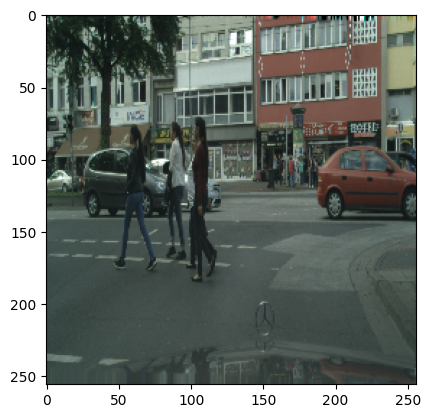

(256, 256, 2)
[0. 1.]


In [26]:
# Test preprocess_rgb
test_image = Image.open(os.path.join(train_rgb_dir, train_rgb_files[0]))
test_image = DataLoader.preprocess_rgb(test_image, input_shape)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

# Test preprocess_label
test_label = Image.open(os.path.join(train_label_dir, train_label_files[0]))
test_label = DataLoader.preprocess_label(test_label, input_shape, road_id, 2)
print(test_label.shape)
print(np.unique(test_label))

In [20]:
num_of_classes = 2
binary_data_loader = DataLoader(train_rgb_dir, train_label_dir, val_rgb_dir, val_label_dir, input_shape, road_id, num_of_classes)
X_train, Y_train, X_val, Y_val = binary_data_loader.generate_binary_datasets()

In [22]:
# Check loaded binary datasets
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))

print(X_train[0].shape)
print(Y_train[0].shape)
print(X_val[0].shape)
print(Y_val[0].shape)

2975
2975
500
500
(256, 256, 3)
(256, 256, 2)
(256, 256, 3)
(256, 256, 2)
